In [20]:
import pandas as pd
import numpy as np

import re

import importlib
import clean_data


importlib.reload(clean_data)
from clean_data import clean_mktcap, clean_price

## 資料匯入

In [21]:
import pandas as pd
import os

# === 設定資料夾 ===
input_folder = "merged_csvs"

# === 要匯入的變數名稱 ===
var_names = [
    "price", "mktcap", "pe_ratio", "pb_ratio", "yd",
    "beta", "earn_yoy", "gross", "rev", "eps"
]

# === 匯入 CSV 檔 ===
for name in var_names:
    file_path = os.path.join(input_folder, f"{name}.csv")

    if os.path.exists(file_path):
        df = pd.read_csv(file_path, index_col=0, encoding="utf-8-sig")

        # === 🟩 index 格式化邏輯 ===
        if name == "price":
            # ✅ 收盤價保留完整日期格式
            df.index = pd.to_datetime(df.index, errors="coerce")
            df.index.name = "date"
        else:
            # ✅ 其他變數轉成 PeriodIndex (freq='M')
            df.index = pd.to_datetime(df.index, errors="coerce").to_period("M")
            df.index.name = "month"

        # 存入全域變數
        globals()[name] = df
        print(f"✔ 已載入 {name} ({df.shape[0]} rows × {df.shape[1]} cols)")
    else:
        print(f"⚠ 找不到檔案：{file_path}")

print("\n✅ 所有指定變數已載入完成 — price 為 DatetimeIndex，其餘為 PeriodIndex(freq='M')。")


returns = price.pct_change()



#金融保險
finance_corp = pd.read_excel("因子資料全.xlsx",sheet_name="金融保險（含下市櫃）")



✔ 已載入 price (5634 rows × 506 cols)
✔ 已載入 mktcap (275 rows × 506 cols)
✔ 已載入 pe_ratio (275 rows × 506 cols)
✔ 已載入 pb_ratio (275 rows × 506 cols)
✔ 已載入 yd (275 rows × 506 cols)
✔ 已載入 beta (275 rows × 506 cols)
✔ 已載入 earn_yoy (273 rows × 506 cols)
✔ 已載入 gross (90 rows × 506 cols)
✔ 已載入 rev (90 rows × 506 cols)
✔ 已載入 eps (275 rows × 506 cols)

✅ 所有指定變數已載入完成 — price 為 DatetimeIndex，其餘為 PeriodIndex(freq='M')。


C:\Users\USER\AppData\Local\Temp\ipykernel_19328\2750205928.py:39: FutureWarning:

The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



## 產出Alpha

In [22]:
import importlib
import alpha
import pe
import yeild
import revenue_growth
import eps_growth

importlib.reload(alpha)
importlib.reload(pe)
importlib.reload(yeild)
importlib.reload(revenue_growth)
importlib.reload(eps_growth)

from alpha import build_sample_pool, build_sample_pool_ex_fin,momentum_signal , pool_to_alpha ,pe_low_signal,dy_high_signal,yoy_high_signal,margin_growth_signal,eps_growth_signal


In [23]:
top200 = build_sample_pool(mktcap)
top200_nofin = build_sample_pool_ex_fin(mktcap,finance_corp)
top200_alpha = pool_to_alpha(returns, top200)

In [24]:
momentum_01_alpha = momentum_signal(returns, top200,lookback_months=1)
momentum_03_alpha = momentum_signal(returns, top200,lookback_months=3)
momentum_06_alpha = momentum_signal(returns, top200,lookback_months=6)

pe_low_01_alpha = pe_low_signal(returns, pe_ratio, top200_nofin)

pb_low_01_alpha = pe_low_signal(returns, pb_ratio, top200_nofin)

high_yield_alpha = dy_high_signal(returns, yd, top200,require_positive=False)

low_vol_alpha =  pe_low_signal(returns, beta, top200, require_positive=True)

high_yoy_alpha = yoy_high_signal(returns, earn_yoy,top200,yoy_cap_ratio=200,      # 200%
    yoy_is_percent=True,    # 你的數據是百分比
    require_positive=False  # 依你的條件，不強制 >0
)

In [25]:
sig_margin = margin_growth_signal(
    returns=returns, 
    gross=gross, 
    operating=rev, 
    mktcap_pool=top200_nofin
)

In [26]:
eps_up = eps_growth_signal(
    returns=returns,
    eps_est=eps,
    mktcap_pool=top200,
    increase_strict=True,   # 嚴格 > 才算成長
    require_positive=True   # EPS 必須為正
)

In [27]:
def alp_return(alpha: pd.DataFrame, returns: pd.DataFrame) -> pd.Series:
    """
    給定 alpha (0/1 矩陣) 和 returns，計算每日投組報酬。
    """
    weighted_ret = (alpha * returns).sum(axis=1)
    counts = alpha.sum(axis=1)
    return (weighted_ret / counts).dropna()

######

# 2003-2025績效表現分析

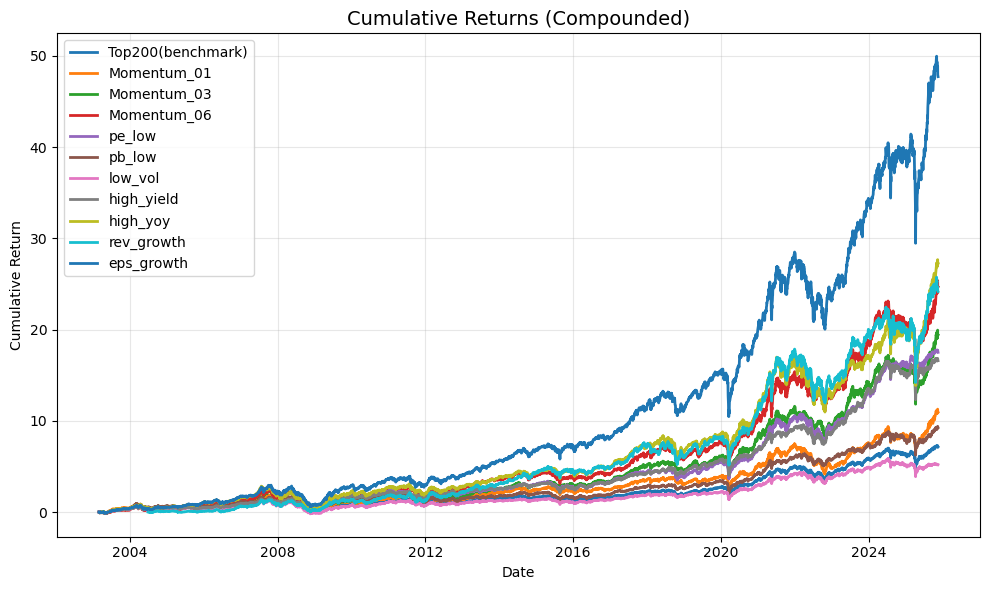

In [28]:
import matplotlib.pyplot as plt

def plot_cum_returns(*series, labels=None, title="Cumulative Returns (Compounded)"):
    """
    輸入一個或多個 return series，畫複利累積報酬
    series: 每個是 pd.Series (index=日期, values=日報酬)
    labels: 對應的名稱
    
    """
    plt.figure(figsize=(10, 6))
    
    for i, s in enumerate(series):
        cum = (1 + s).cumprod() - 1
        label = labels[i] if labels else f"Series {i+1}"
        plt.plot(cum.index, cum.values, label=label, linewidth=2)
    
    plt.title(title, fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

ret_top200 = alp_return(top200_alpha, returns)
ret_mom = alp_return(momentum_01_alpha, returns)
ret_mom3 = alp_return(momentum_03_alpha, returns)
ret_mom6 = alp_return(momentum_06_alpha, returns)
ret_pe_low1 = alp_return(pe_low_01_alpha, returns)
ret_pb_low1 = alp_return(pb_low_01_alpha, returns)
ret_low_vol = alp_return(low_vol_alpha, returns)
ret_high_yield = alp_return(high_yield_alpha,returns)
ret_high_yoy = alp_return(high_yoy_alpha,returns) #lag兩個月
ret_rev_growth = alp_return(sig_margin,returns)
ret_eps_growth = alp_return(eps_up,returns)
plot_cum_returns(ret_top200, ret_mom,ret_mom3,ret_mom6,ret_pe_low1,ret_pb_low1,ret_low_vol,ret_high_yield,ret_high_yoy,ret_rev_growth,ret_eps_growth,labels=["Top200(benchmark)", "Momentum_01","Momentum_03","Momentum_06","pe_low","pb_low","low_vol","high_yield","high_yoy","rev_growth","eps_growth"])


In [29]:
import pandas as pd
import numpy as np

def perf_summary(returns_dict: dict, freq: int = 252, rf: float = 0.0) -> pd.DataFrame:
    """
    統整策略績效：年化報酬、年化波動率、Sharpe ratio
    
    returns_dict: dict[str, pd.Series] {策略名稱: 日報酬序列}
    freq: 一年交易日數 (預設 252)
    rf: 無風險利率 (日化)，預設 0
    
    回傳：pd.DataFrame
    """
    rows = []
    for name, r in returns_dict.items():
        r = r.dropna()
        ann_ret = (1 + r).prod() ** (freq / len(r)) - 1
        ann_vol = r.std() * np.sqrt(freq)
        sharpe = (ann_ret - rf) / ann_vol if ann_vol > 0 else np.nan
        rows.append([ann_ret, ann_vol, sharpe])
    
    return pd.DataFrame(rows, index=returns_dict.keys(),
                        columns=["Annual Return", "Annual Volatility", "Sharpe Ratio"])

# ---------------- 使用範例 ----------------
perf_table = perf_summary({
    "Momentum_01": ret_mom,
    "Momentum_03": ret_mom3,
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "eps_growth": ret_eps_growth,
    "benchmark":ret_top200
})

perf_table.sort_values(by="Annual Return")


,Annual Return,Annual Volatility,Sharpe Ratio
Low_vol,0.085638,0.186335,0.459592
benchmark,0.099035,0.193423,0.512012
PB_low,0.110510,0.200728,0.550547
Momentum_01,0.118154,0.209372,0.564326
High_yield,0.137777,0.175230,0.786266
PE_low,0.140380,0.197518,0.710719
Momentum_03,0.145408,0.213777,0.680188
Momentum_06,0.157295,0.220002,0.714970
High_yoy,0.162921,0.213388,0.763500
Rev_growth,0.167009,0.223721,0.746506


In [30]:
import interval_report
importlib.reload(interval_report)

from interval_report import perf_report,factor_monthly_heatmap_plotly,factor_rank_tile,factor_rank_tile_full

## 函數1:指定區間因子報酬報表

c:\Users\USER\OneDrive\桌面\因子投資_ver1\interval_report.py:61: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



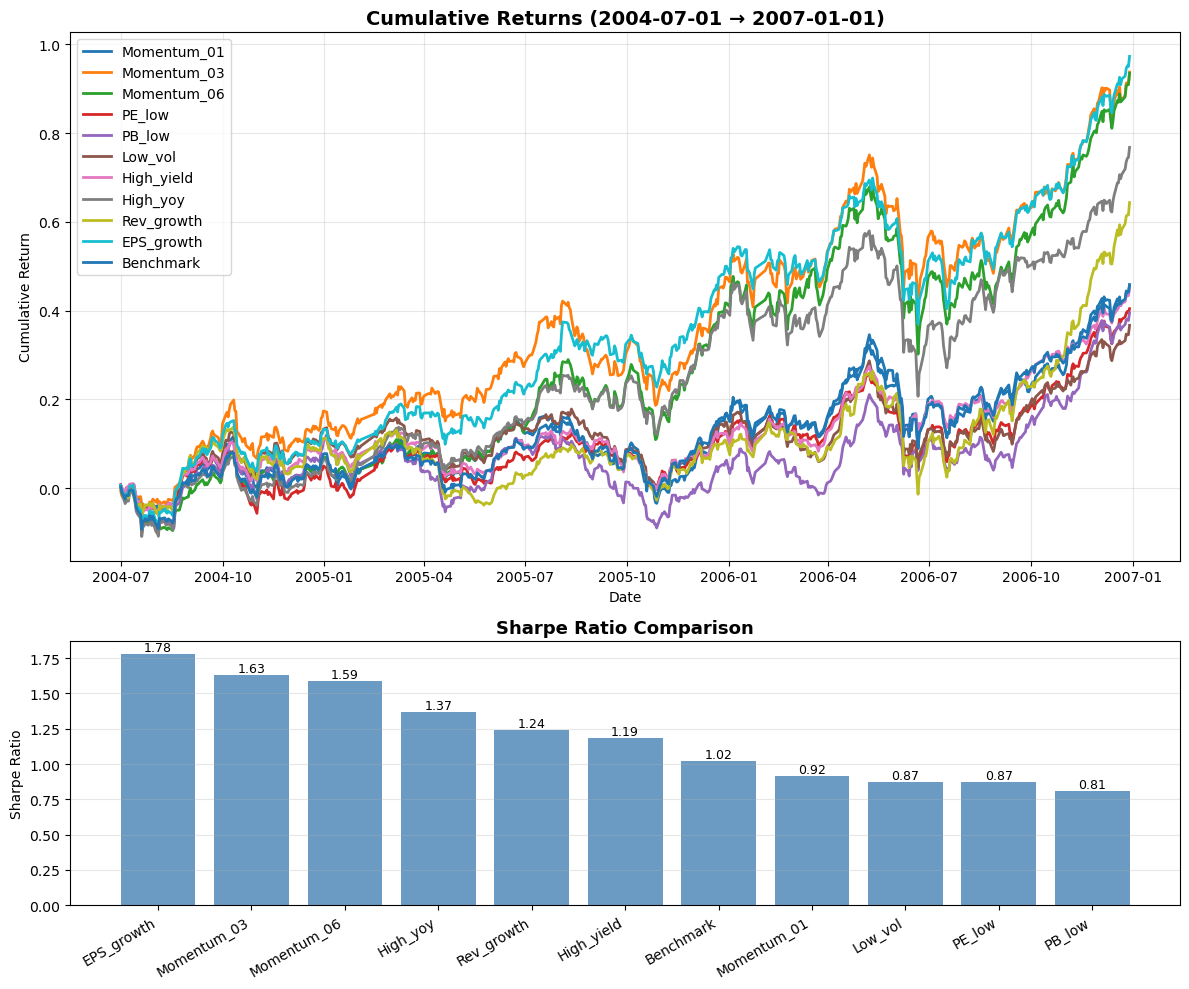

             Annual Return  Annual Volatility  Sharpe Ratio  Total Return
Momentum_01         0.1648             0.1796        0.9179        0.4582
Momentum_03         0.3068             0.1884        1.6281        0.9377
Momentum_06         0.3061             0.1930        1.5863        0.9351
PE_low              0.1473             0.1689        0.8718        0.4045
PB_low              0.1441             0.1779        0.8100        0.3948
Low_vol             0.1347             0.1544        0.8729        0.3669
High_yield          0.1626             0.1370        1.1868        0.4512
High_yoy            0.2593             0.1898        1.3659        0.7681
Rev_growth          0.2226             0.1796        1.2398        0.6437
EPS_growth          0.3164             0.1777        1.7811        0.9732
Benchmark           0.1649             0.1615        1.0211        0.4584


In [31]:
factors = {
    "Momentum_01": ret_mom,
    "Momentum_03": ret_mom3,
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "EPS_growth": ret_eps_growth,
    "Benchmark" : ret_top200
}


start= "2004-07-01"
end= "2007-01-01"

# start= "2021-01-01"
# end= "2025-05-01"


report = perf_report(factors, start_date=start, end_date=end)
print(report.round(4))


## 函數2:最近一年因子月表現熱力圖

In [32]:
returns_dict = {
    "Momentum_01": ret_mom,
    
    "Momentum_06": ret_mom6,
    "PE_low": ret_pe_low1,
    "PB_low": ret_pb_low1,
    "Low_vol": ret_low_vol,
    "High_yield": ret_high_yield,
    "High_yoy": ret_high_yoy,
    "Rev_growth": ret_rev_growth,
    "EPS_growth": ret_eps_growth,
    
}

_ = factor_rank_tile_full(
    returns_dict=returns_dict,
    periods=12,
    freq="M",                   # "M" / "W" / "Y"
    
    text_size=8,              
    # save_html="factor_rank_last12_months.html",
)


c:\Users\USER\OneDrive\桌面\因子投資_ver1\interval_report.py:312: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

c:\Users\USER\OneDrive\桌面\因子投資_ver1\interval_report.py:337: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



##### 

In [33]:
# internship、project detail，including github clear

# come up with reasearch plan

# grad school course plan

#@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@ email to prof manager

# motivation 

# conclusion 





# 函數3: 當日持股明細

In [34]:
def porfolio_list(alpha,date):
    return alpha.columns[(alpha.loc[date]==1)]

In [35]:
(porfolio_list(pe_low_01_alpha,"2025-01-20"))

Index(['1102', '1210', '1808', '2006', '2101', '2201', '2204', '2206', '2211',
       '2303', '2327', '2347', '2357', '2371', '2385', '2474', '2504', '2603',
       '2606', '2609', '2610', '2615', '2618', '2637', '2809', '2812', '2834',
       '2855', '2881', '2882', '2883', '2885', '2887', '2888', '2890', '2891',
       '2915', '3005', '3044', '3406', '4938', '4958', '5483', '5871', '5903',
       '6005', '6121', '6147', '6176', '6239', '6412', '6488', '6605', '6670',
       '9904', '9941', '9945'],
      dtype='object')

# 函數4: 投資組合貢獻最多的個股

In [36]:
from portfo_analysis import top_contributors_report

In [37]:

def porfolio_list_period(alpha,start,end,num=30):
    selected_days = alpha.loc[start:end].sum(axis=0)
    t = selected_days.sort_values(ascending=False).head(num).index
    tickers = t
    stats_df, port_ret = top_contributors_report(
        returns, tickers, start_date=start, end_date=end, top_n=10
    )
    return stats_df





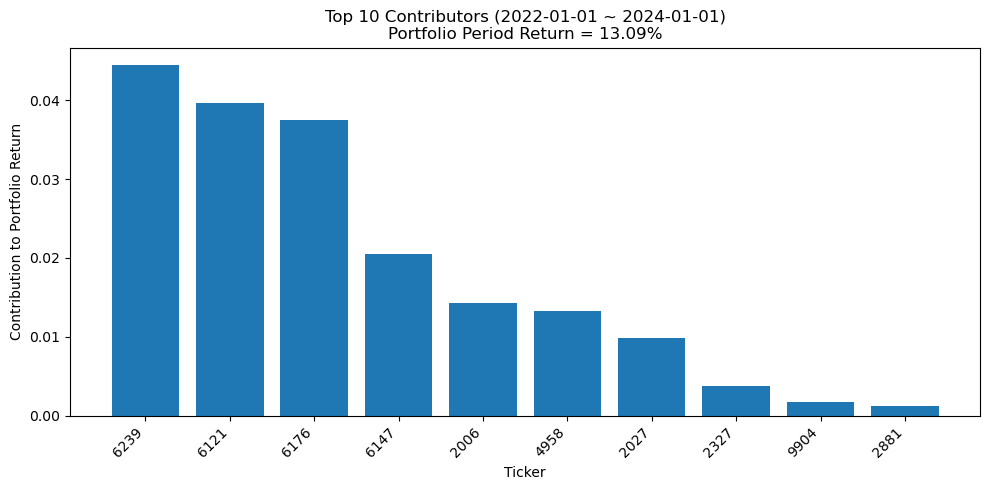

,Annual Return,Annual Volatility,Sharpe Ratio,Period Return,Weight,Contribution
6239,0.337112,0.225452,1.495270,0.666277,0.066667,0.044418
6121,0.313602,0.248659,1.261175,0.593772,0.066667,0.039585
6176,0.284810,0.196116,1.452251,0.561397,0.066667,0.037426
6147,0.173760,0.204164,0.851080,0.307910,0.066667,0.020527
2006,0.143283,0.257232,0.557019,0.214135,0.066667,0.014276
4958,0.140951,0.274576,0.513339,0.198556,0.066667,0.013237
2027,0.118794,0.287140,0.413713,0.147232,0.066667,0.009815
2327,0.093270,0.348935,0.267298,0.056900,0.066667,0.003793
9904,0.037573,0.217453,0.172785,0.026268,0.066667,0.001751
2881,0.031337,0.206450,0.151791,0.018740,0.066667,0.001249


In [38]:
porfolio_list_period(pe_low_01_alpha,"2022-01-01","2024-01-01",num=15)